# Going Down the EECS Stack Lab 11: Controls & Embedded Systems

By Alex Kristofferson, Simon Guo, Bryan Ngo, Leyla Kabuli, and Rohan Juneja

# Understanding Feedback Control


## Lecture Recap & Motivation

> Skip this part if you are comfortable with the lecture content.

In the lecture, we talked about embedded systems: systems that process input from the environment and exert some output to achieve specific goals.
The system architecture can be summarized in the diagram below.

![Embedded System Control Flow](Embedded-Systems.jpg)

Since we are operating in a physical world, we must interface with analog signals.

1. Sensors typically read in analog signals (e.g., voltage measurement on thermistor that depends on temperature).
We must convert to digital signals for embedded systems to understand.
2. When we want to use an actuator to do something (e.g., changing motor speed), we must give the actuator an analog signal (e.g., how many volts for the motor), and that has to be converted from the digital signals.

Because of the need for conversion between the digital and analog world, and due to the non-idealities of the real world not always working in our favor, we have some challenges:

1. Sensor reading might be noisy and fluctuating; we can use **filtering** to filter out some noise and use a [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) to focus on specific frequencies.
2. When we output to the actuator, let's say we want the motor to increase to 60 rpm; it might not achieve that precisely since many factors play in the physical world. We must continuously adjust, and that's the topic of this lab, **controls**.

## What are controls and controllers?

Now that we learned about why we need control: to let our actuator perform in the way we want. 
There are mostly two types of control:

- **Open-Loop Control**: We calculate the output and give that to the actuator.
We just let it run, and we don't know what the effect is or if it is performing at the desired situation we want.
Think about powering a fan; you just need it to spin rather than checking if it is at a certain RPM.
- **Closed-Loop Feedback Control**: As you can see, open-loop control does not solve the issue we mentioned before.
Thus, we need a way to adjust the output to the actuator based on the system's situation.
**State** is a word that describes the state or specific information about a system at a particular time. 

For example, you are heating a room.
Your state will be the current temperature of the room.
You want to reach the desired temperature.
If you can measure the current state, you can adjust the power of the heater.
If your room is still too cold, you increase the power.
If the current temperature is closed to the desired temperature, you can reduce power.
If it is over the temperature, you can stop the heater for some time. 

You just saw an example of a closed-loop feedback system, where the signal to the controller/actuator is based on the state of the system.
You are getting **feedback** from the state of the system to adjust your control signals further. 

To summarize, you continuously apply a signal to the actuator; the actuator does its work.
You check the system's updated state, recalculate the new signal needed to the actuator, and repeat.
This is like a cycle, so we call this **closed-loop**.

There are _many_ types of controllers that help us achieve this. They differ in how feedback is weighted or how the state is translated into the new control signal. To name a few:
- [Proportional–Integral–Derivative](https://en.wikipedia.org/wiki/PID_controller) (PID) Controller
- [Linear-Quadratic Regulator](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator) (LQR)
- Nonlinear Controllers
- Robust Control

In this lab, we will focus on PID controllers and see how they can be used to stabilize systems that are generally very unstable. Very powerful indeed!

# Proportional–Integral–Derivative (PID) Control

Let's take a look at what PID control is and how we can use them.
On a high level, the controller calculates an error value, called $e(t)$, representing the difference between the current state and desired state. Having that error value or difference in mind, we can apply a correction input into the system (output signal to the actuator) based on the combined effect of **proportional, integral, and derivative terms**. That is why it is called PID.

Here is a diagram that illustrates the process we just described.

![PID Control Flow](PID.png)

Notice a loop in the diagram. With this closed-loop feedback, our current state can be used to adjust our next control signal, eventually leading the system to **stabilize** around the desired state.

The equation is shown below; notice the three terms that apply proportional, integral, and derivative operations on the $e(t)$ value.

$$u(t) = K_i e(t) + K_i \int_{0}^{t} e(\tau) \, d\tau + K_d \frac{de(t)}{dt}$$

The significance of each term is:
- $K_p e(t)$ accounts for the _present error_ in our system.
- $K_i \int_0^t e(\tau) \, d\tau$ accounts for the entire history of the system and accounts for _past error_.
- $K_d \frac{de(t)}{dt}$ accounts for how rapidly the error changes and accounts for _future error_.

$u(t)$ represents the control signal we calculated to apply to the actuator, based on our current state.

As mentioned, there are three terms we are using to calculate that $u(t)$. Our three $K$ values respectively tune the three methods (proportional, integral, and derivative); you can think about them as weights or coefficients that scale each operation's effect.

These $K$ factors are called tuning constants, and they are unique to each application. Determining these factors is an area worth investigating by itself. The unique set of values chosen for these $K$ values create a **controller** from this control method!

PID controllers are widely used in cyber-physical systems, such as a car! Try out the car PID controller demo below and see how you can adjust the 3 $K$ tuning constants to build a PID controller to make the car stable!

In [9]:
%%html
<iframe src="https://chev.me/pid-demo/" width="800" height="600">

# Applying PID Control to an Inverted Pendulum

Have you ever balanced a pencil on your finger? Everyone knows that's hard to do. However, with a PID controller, that might be possible!

In this part, we will walk through how you will keep an inverted pendulum upright using the PID controller we just learned. This notebook will serve as a simulation, but you can build a system like this in real life. Check out [this demo from EE 128](https://www.youtube.com/watch?v=6MEfrPqvptA). In this case, every time the pendulum is hit (aka the system state changes), we can apply control signals to make it upright again! That's how powerful controls are.

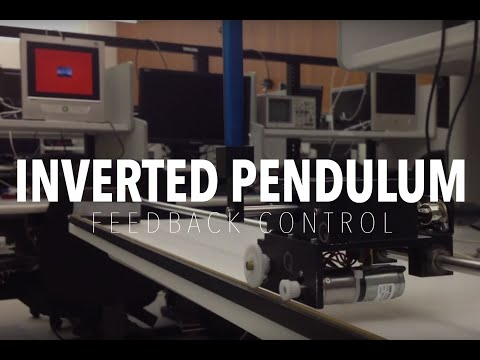

In [10]:
from IPython.display import YouTubeVideo

YouTubeVideo('6MEfrPqvptA', width=800, height=300)

First, we need to import some libraries to help us with the calculation. 

In [1]:
from dataclasses import dataclass

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np

Here we imagine the system is composed of a inverted pendulum on top of a cart. The pendulum is unstable (not upright and is falling), so we must move the cart to keep it stable and balanced. To do so, we can apply a force on the cart at each timestep.

<img src="inverted-pendulum.png" alt="Inverted Pendulum" style="width: 300px;"/>

Note that we are creating classes for these objects. Object-oriented programming is essential in simulations and representing the physical world. We can create many instances of these objects with these classes, each with associated data representing its physical properties.

We mentioned **state** represents the current physical description of the system. In this case, we focus on the pendulum, and the states we account for are its `length`, `theta`, and `ball_mass`. The only state that can change is `theta`, the angle between the pendulum from its upright position. To keep it upright, we must make `theta` go to 0.

**Our goal**: Apply force on the cart, so `theta` **reaches** and **stabilizes** at zero (upright position!)

In [2]:
@dataclass
class Cart:
    x:    float  
    mass: float
    y:    float = 0

@dataclass
class Pendulum:
    length:    float
    theta:     float
    ball_mass: float

Let's initiate some constants for simulation. It is always good to put them at the start of a simulation and declare them as global variables in case we want to change them in the future. Here we only need to consider the gravitational constant $g$. What are some other factors that we can account for in a more complex situation?

In [3]:
#Constants:
g = 9.81

Now our goal will be to make a PID Controller that will stabilize the pendulum at the upright position. Here is the generic formula of a PID controller: 

$$u(t) = K_p e(t) + K_i \int_{0}^{t} e(\tau) \, d\tau + K_d \frac{de(t)}{dt}$$

We are giving the controller our $e(t)$ (error function), the difference between the desired state and the current state.
We have the gains (the three $K$ constants) tuned and passed in here. With this information, we can amplify the effect of proportional, integral, and derivative operations on the $e(t)$ by the three $K$ constants, respectively. The combined effect is our control signal $u(t)$!

We will keep using the controller to calculate the next control signal, based on every new state of our $e(t)$. Hopefully, we will make the pendulum upright over time!

Now, this formula may look a bit complicated, but we can do this part by part. Also, it is impossible to calculate the integral or derivative since we don't have the actual error function, so we will be using approximations.

## Proportional Control
$$u_p(t) = K_i e(t)$$
This is the easiest part to calculate. We simply adjust our output based on how much the error is. The farther away we are from the desired state, the more force we apply!
Fill in the function below to calculate the proportional component of PID, from K_p and the current error value.

In [ ]:
def proportional_control(error: float, Kp: int) -> float:
    """
    Proportional control function.
    """
    proportional_signal = # fill in here (don't overthink it!)
    return proportional_signal

# Derivative Control
$$u_d(t) = K_d \frac{de(t)}{dt}$$

This formula simply means that if the error is changing at a higher rate (the derivative measures how fast the error is changing with respect to time), we want to adjust the signal output. For example, if the error is decreasing rapidly, we may want to reduce the output signal to make sure we don't overshoot the desired state (in the case of the pendulum, we don't want to go past the upright position).

There is one issue here, though: we do not actually have the error function, so we cannot calculate the derivative. However, we can use a secant line approximation (diagram below). The idea is to take the last two points of the error function, and calculate the slope between them (the change in error over the change in time). This calculation is the same for how you would calculat the slope of a linear line (rise over run)!

In the diagram below, the black line (line between two close points), approximates at what rate the function is changing at that point.

<img src="secant.svg" alt="Secant Line" style="width: 300px;"/>

Our formula becomes,
$$u_d(t) = K_d \frac{e(t)-e(t_{prev})}{t-t_{prev}}$$

For simplicity, in the function below we denote $t-t_{prev}$ as `dt`. Fill in the function below to calculate the derivative component of PID.

In [ ]:
def derivative_control(error: float, previos_error: float, Kd: int, dt: float) -> float:
    """
    Derivative control function.
    """
    approximate_derivative = # fill in here
    derivative_signal = # fill in here (don't overthink it!)
    return derivative_signal

# Integral Control
$$u_i(t) = K_i \int_{0}^{t} e(\tau) \, d\tau$$

This formula is simply calculating the amount of accumulated error over time. This is done by taking the area under the curve of the error function. If this area is larger, that means that the error is remaining at a nonzero quantity for a longer time, and therefore we may need a boost in output signal.

<img src="integral.jpg" alt="Integral Diagram" style="width: 300px;"/>

Now, again since we don't have the function we cannot find the actual integral. But we can approximate it by using a rectangular approximation for the area. See the diagram below.

<img src="rectangular_method.gif" alt="Integral Diagram" style="width: 300px;"/>

Here, the height of each rectangle is the value of the error at a particular moment in time (which we have for some poitns in time), and the width of each rectangle is the time between a given point and the point before/after it (we call this `dt` in our function).

To avoid a lot of recalculations, we can keep a running sum of the area under the curve. Then, each time we recieve a new error value, we simply add its rectangle to the area.

Thus, we get a formula that looks something like this where $I_{prev}$ is the previous integral value (area under curve):

$$u_i(t) = K_i ( I_{prev} + (t-t_{prev})e(t) ) $$

Fill in the code below to calculate the integral component of PID.

In [ ]:
def integral_control(error: float, previous_integral: float, Ki: int, dt: float) -> float:
    """
    Integral control function.
    """
    integral = # fill in here
    integral_signal = # fill in here (don't overthink it!)
    return integral, integral_signal

Now, let's add up all the components from our previous functions to make a PID controller!

In [4]:
def pid_control(error: float, previous_error: float, previous_integral: float, dt: float, Kp: int, Ki: int, Kd: int) -> tuple[float, float]:
    """Using PID to find control inputs."""

    proportional_component = # fill in here (use your function from earlier!)
    integral, integral_component = # fill in here (use your function from earlier!)
    derivative_component = # fill in here (use your function from earlier!)
    output_force = # fill in here (don't over think it!)
    return output_force, integral

SyntaxError: invalid syntax (1518579421.py, line 4)

In [5]:
def pid_control(error: float, previous_error: float, integral: float, dt: float, Kp: int, Ki: int, Kd: int) -> tuple[float, float]:
    """Using PID to find control inputs."""

    integral += dt * error
    return error * Kp + (error-previous_error)/dt * Kd + Ki * integral, integral

Here is some code translating the force into physical effect on the cart position. It also determines the pendulum's angle/orientation after the output force is applied to the system by the actuator. Remember that our PID controller calculated the force/control signal! After we apply this force, our state of the pendulum changes, `pendulum.theta`, so we can use this new state to feed into the PID controller again in the next timestep.

In [6]:

def apply_force(
        cart: Cart,
        pendulum: Pendulum,
        F: float,
        dtime: float,
        x_2: float,
        dtheta: float,
        theta_2: float,
        previous_dtime: float) -> None:
    """These apply a force F using the equations of motion for the cart and pendulum."""
    
    sin_theta = np.sin(pendulum.theta)
    cos_theta = np.cos(pendulum.theta)

    a_theta_num = (cart.mass + pendulum.ball_mass) * g * sin_theta + F * cos_theta - (pendulum.ball_mass * dtheta**2 * pendulum.length * sin_theta * cos_theta)
    a_theta_den = pendulum.length * (cart.mass + pendulum.ball_mass * sin_theta**2)
    a_theta = a_theta_num / a_theta_den

    a_x_num = (pendulum.ball_mass * g * sin_theta * cos_theta) - (pendulum.ball_mass * pendulum.length * sin_theta * dtheta**2) + F
    a_x_den = cart.mass + pendulum.ball_mass * sin_theta**2
    a_x = a_x_num / a_x_den
    
    cart.x += (dtime**2 * a_x) + (((cart.x - x_2) * dtime) / previous_dtime)
    
    pendulum.theta += (dtime**2 * a_theta) + (((pendulum.theta - theta_2) * dtime) / previous_dtime)


Here is our implementation of $e(t)$, the difference between the current state (theta of the pendulum) and the desired state. Remember, we want our pendulum to be upright, so the desired `theta` will be 0 as `theta` is the angular difference between the pendulum and the upright position. 

In [7]:
def find_error(pendulum):
    """This function returns the error."""
    error = pendulum.theta % (2 * np.pi)
    if error > np.pi:
        error -= 2 * np.pi
    return error

Below is a helper function for visualization.
We would like to see the following information:

- **errors**, or $e(t)$, how far away the pendulum is from upright position 
- **theta**, the state of the pendulum, which is the angular position of the pendulum.
- **force**, or $u(t)$, the output from our PID controller
- **x**, or `cart.x`, the location of the cart on the $x$-axis

In [8]:
def plot_graphs(times, errors, theta, force, x):
    """This function plots all the graphs."""

    _, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    
    ax1.plot(times, errors)
    ax1.set_ylabel("Error [m]")

    ax2.plot(times, theta)
    ax2.set_ylabel("Angle [rad]")

    ax3.plot(times, force)
    ax3.set_ylabel("Force [N]")

    ax4.plot(times, x)
    ax4.set_ylabel("Position [m]")
    ax4.set_xlabel("Time [s]")

    plt.show()

The next block puts all our components together to build a simulation of our controller trying to balance the Pendulum, over a period of time.

In [13]:
SIM_TIME = 5  # if you have more memory, feel free to increase this
TIME_STEP = 0.1

def run_sim(mass_of_cart: float, mass_of_ball: float, Kp: int, Ki: int, Kd: int, plot: bool = True):
    theta_values = []
    print(f"Simulating with mass of cart {mass_of_cart} kg, mass of ball {mass_of_ball} kg, {Kp=}, {Ki=}, {Kd=}")

    # instantiates cart and pendulum objects
    cart = Cart(0, mass_of_cart)
    pendulum = Pendulum(1, 0.3, mass_of_ball)

    # Record data for plotting
    times = np.arange(0, SIM_TIME + TIME_STEP, TIME_STEP)
    errors, force, theta, eval_times, x = [], [], [], [], []
    previous_timestamp = times[0]

    d_theta = 0
    theta_1 = pendulum.theta
    theta_2 = pendulum.theta
    x_1 = cart.x
    x_2 = cart.x
    previous_error = find_error(pendulum)
    integral = 0
    previous_dtime = 0

    for idx, current_time in enumerate(times):  # calculating timestep (dtime) and the current error.
        dtime = current_time - previous_timestamp
        error = find_error(pendulum)

        if previous_dtime != 0:  # this condition is to make sure that theta_dot is not infinity in the first step
            # finding the derivatives of the angle and x position over the timestep.
            d_theta = (theta_1 - theta_2) / previous_dtime

            # finding the control and applying it to the card.
            F, integral = pid_control(error, previous_error, integral, dtime, Kp, Ki, Kd)
            apply_force(cart, pendulum, F, dtime, x_2, d_theta, theta_2, previous_dtime)

            # for plotting the graphs
            force.append(F)
            x.append(cart.x)
            errors.append(error)
            theta.append(pendulum.theta)
            eval_times.append(times[idx])

        # Update the variables
        previous_dtime = dtime
        previous_timestamp = current_time
        previous_error = error

        theta_2 = theta_1
        theta_1 = pendulum.theta
        theta_values.append(pendulum.theta)
        x_2 = x_1
        x_1 = cart.x

    if plot:
        plot_graphs(eval_times, errors, theta, force, x)
    return theta_values
    

## PID Controller in Action

We have built the simulation so let's now run it! See how over time, the PID controller is applying forces (see *Force*) based on the state (*Theta* and *Error*), and hopefully bringing the error to 0, meaning we have successfully kept our pendulum upright!

Try the following!

1. Observe the graph. Do you see some oscillations? Do we sometimes overcorrect? Do you notice how closed-loop feedback control can eventually bring everything to stability in the end?
2. Adjust the `mass_of_cart` and `mass_of_ball`. See how changing the physical properties of the simulation changes the graph.
3. Adjust the `Kp`, `Kd`, `Ki`. We know these are constants (or gains) that amplify proportional, integral, and derivative operations, whose weighted net effect generates the force applied. These constants define each controller, so try to change them and see how the system responds. Are you able to create a controller that brings the system to stability faster?

<font color='red'>**Warning:**</font> The notebook might take some time to recalculate and plot every time you move the slider. This notebook also suffers from intensive memory usage. Thus after a few slider adjustments, we recommend you restart the kernel and run all to release some of the memory used and then continue to try new values. Alternatively, you can manually change the `value` argument of every `ipywidgets.IntSlider` in the `interact` function.


In [24]:
ipywidgets.interact(run_sim,
                    mass_of_cart=ipywidgets.IntSlider(min=1, max=10, step=1, value=5),
                    mass_of_ball=ipywidgets.IntSlider(min=1, max=10, step=1, value=1),
                    Kp=ipywidgets.IntSlider(min=-200, max=200, step=5, value=-150),
                    Ki=ipywidgets.IntSlider(min=-200, max=200, step=5, value=-20),
                    Kd=ipywidgets.IntSlider(min=-200, max=200, step=5, value=-20))

interactive(children=(IntSlider(value=5, description='mass_of_cart', max=10, min=1), IntSlider(value=1, descri…

<function __main__.run_sim(mass_of_cart: float, mass_of_ball: float, Kp: int, Ki: int, Kd: int, plot: bool = True)>

## Interactive Visual
Once you find some Kp, Ki, Kd values that work, insert them into the code below to see a visualization of how your pendulum would settle into place!

In [27]:
# thanks to chatgpt for this simulation!
# fill in your values here
Kp = -15
Ki = -20
Kd = -20

from matplotlib.patches import Rectangle

# === Simulation parameters ===
L = 1.0          # Pendulum length
dt = 0.1
t_max = 5.0
times = np.arange(0, t_max, dt)

# === Get theta values from your real sim function ===
theta_values = run_sim(mass_of_cart=5, mass_of_ball=1, Kp=Kp, Ki=Ki, Kd=Kd, plot=False)
theta_values = theta_values[:len(times)]  # Trim if needed

# === Set up plot ===
fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')

# === Draw the cart ===
cart_width = 0.4
cart_height = 0.2
cart_y = -0.1  # Slightly below the pendulum pivot

cart = Rectangle((-cart_width / 2, cart_y), cart_width, cart_height, color='gray')
ax.add_patch(cart)

# === Create pendulum line and bob ===
pendulum_line, = ax.plot([], [], 'o-', lw=2, markersize=10, color='black')

# === Initialization ===
def init():
    pendulum_line.set_data([], [])
    return pendulum_line, cart

# === Update function for animation ===
def update(frame):
    angle = -theta_values[frame]  # Flip pendulum direction
    x = L * np.sin(angle)
    y = L * np.cos(angle)

    origin_x = 0
    origin_y = cart_y + cart_height

    pendulum_line.set_data([origin_x, origin_x + x], [origin_y, origin_y + y])
    return pendulum_line, cart

# === Animation ===
ani = FuncAnimation(fig, update, frames=len(theta_values), init_func=init, interval=dt * 1000, blit=True)
plt.close(fig) 
# === Display in Jupyter ===
HTML(ani.to_jshtml())

Simulating with mass of cart 5 kg, mass of ball 1 kg, Kp=-15, Ki=-20, Kd=-20


## More Control Theory Simulations

Check out [this demo from OpenAI](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) for another example of an inverted pendulum.
You can also check out [the other classic control simulations](https://www.gymlibrary.dev/environments/classic_control/).

# Congratulations! 

You now know what control is and how a PID controller works! Note, PID is only one approach, where we use proportional, integral, derivative operations on $e(t)$. Some other questions to consider:
- Can you come up with a different controller? What happens if we leave out one of the terms in PID?
- What are the pros and cons of each kind of controller?
- How can you decide when to use which one? How do you determine the gains/tuning constants/ $K$?

These are all things that you can explore throughout your journey at Berkeley EECS.

To summarize this lab, the key takeaways are:

1. Embedded Systems sense information and perform actions.
2. The real world is complicated, and when we perform actions, we might not reach the goal at one go. We need constant adjustment to get to and stabilize at the desired state.
3. We can design a closed-loop feedback system, where the signal to the actuator is dependent on the current state of the system. In other words, the output of the controller depends on the previous input into the controller (the state). 
4. We coded a PID controller. It uses proportional, integral, and derivative operations to create a control signal. We scale each operation by applying a gain/tuning constant/ $K$ / weight. These $K$ values are characteristics of our PID controller.
5. We simulated this controller by building a rudimentary physics engine and evaluated its performance. We tried to improve its performance by adjusting the $K$ values (aka updating our controller design). 

# Submission

Answer the following questions on Gradescope:

1. Take a look at the online PID demo. How does the system's response to a change in "setpoint" when you make the "Time Constant" very small/large?
2. How does the system react with a very large P, I, or D term (relative to the default values)?
3. Try fiddling around with the PID gains in our cart pendulum demo. What values of $K_p$, $K_i$, $K_d$ can you choose to make the system settle to zero error faster than the default? _Hint: there are multiple possible answers._
4. Take a look at the Wikipedia entry for [PID manual tuning](https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller#Manual_tuning). How did you use this guide to make your system settle even _faster_?

# Resources
If you find this interesting, check out these courses you can take at Berkeley!

- EECS 16B: Designing Information Devices and Systems II
- EE C106A: Introduction to Robotics
- EE C106B: Robotic Manipulation and Interaction
- EE 120: Signals and Systems
- EECS 126: Probability and Random Processes
- EE C128: Feedback Control
- EE 221A: Linear Systems
- EE 222: Nonlinear Systems


Controls are incredibly important and useful for building embedded systems, robots, and machine learning applications. This is definitely something worth learning.

## References

Thanks to the work of these folks!
* https://github.com/Nikkhil16/Inverted_Pendulum
* https://sites.google.com/site/fpgaandco/pid
* https://www.moorepants.info/blog/npendulum.html
* https://github.com/gilbertgede/idetc-2013-paper/blob/master/n-pendulum-control.ipynb